In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn # neural networks
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# load and preprocess data
df = pd.read_csv("../Dataset/Amazon Sale Report.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')
df = df[['Date','Status','Qty','Amount']]
df = df[df['Status'].str.contains('Shipped')]
df = df.groupby('Date').agg({'Qty':'sum','Amount':'sum'}).reset_index()
df = df[df['Qty'] > df['Qty'].quantile(0.05)]
# Normalise Qty and Amount
sc_qty = MinMaxScaler()
sc_amt = MinMaxScaler()
df['Qty']=sc_qty.fit_transform(df['Qty'].values.reshape(-1,1))
df['Amount'] = sc_amt.fit_transform(df['Amount'].values.reshape(-1,1))

# creating datasets
class tsDataset(Dataset):
    def __init__(self,qty_data,amount_data,seq_len):
        self.qty_data = qty_data
        self.amount_data = amount_data
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.qty_data) - self.seq_len
    def __getitem__(self, index):
        return (self.qty_data[index:index+self.seq_len], self.amount_data[index+self.seq_len])
    
seq_len = 30
qty_values = torch.tensor(df['Qty'].values,dtype=torch.float32)
amount_values = torch.tensor(df['Amount'].values,dtype=torch.float32)
dataset = tsDataset(qty_values,amount_values,seq_len)
dataloader = DataLoader(dataset, batch_size=32,shuffle=True)


In [ ]:
# Combined LSTM and Tranformer model
class LSTMTransformer(nn.Module):
    def __init__(self, input_dim=1, lstm_hidden_dim=64, lstm_layers=2, d_model=64, nhead=4, num_transformer_layers=2,dropout=0.3):
        super(LSTMTransformer, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, lstm_layers, batch_first=True,dropout=dropout)
        self.embedding = nn.Linear(lstm_hidden_dim, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_transformer_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        transformer_input = self.embedding(lstm_out)
        transformer_input = transformer_input.permute(1, 0, 2)  # (seq_len, batch, feature)
        transformer_out = self.transformer(transformer_input, transformer_input)
        out = self.fc(transformer_out[-1])
        return out
# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_transformer_model = LSTMTransformer().to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_transformer_model.parameters(), lr=0.0001)

In [29]:
# training the model
def train_model(model, dataloader, optimizer, epochs=1000):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for seq, target in dataloader:
            seq, target = seq.unsqueeze(-1).to(device), target.unsqueeze(-1).to(device)
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}')

# Train the combined model
print("Training LSTM-Transformer...")
train_model(lstm_transformer_model, dataloader, optimizer)


Training LSTM-Transformer...
Epoch 1/1000, Loss: 0.3923
Epoch 2/1000, Loss: 0.2531
Epoch 3/1000, Loss: 0.1052
Epoch 4/1000, Loss: 0.1565
Epoch 5/1000, Loss: 0.1229
Epoch 6/1000, Loss: 0.0731
Epoch 7/1000, Loss: 0.0990
Epoch 8/1000, Loss: 0.0715
Epoch 9/1000, Loss: 0.0742
Epoch 10/1000, Loss: 0.0647
Epoch 11/1000, Loss: 0.0902
Epoch 12/1000, Loss: 0.0587
Epoch 13/1000, Loss: 0.0712
Epoch 14/1000, Loss: 0.0663
Epoch 15/1000, Loss: 0.0776
Epoch 16/1000, Loss: 0.0681
Epoch 17/1000, Loss: 0.0742
Epoch 18/1000, Loss: 0.0823
Epoch 19/1000, Loss: 0.0702
Epoch 20/1000, Loss: 0.0568
Epoch 21/1000, Loss: 0.0829
Epoch 22/1000, Loss: 0.0544
Epoch 23/1000, Loss: 0.0636
Epoch 24/1000, Loss: 0.0531
Epoch 25/1000, Loss: 0.0653
Epoch 26/1000, Loss: 0.0541
Epoch 27/1000, Loss: 0.0622
Epoch 28/1000, Loss: 0.0572
Epoch 29/1000, Loss: 0.0579
Epoch 30/1000, Loss: 0.0774
Epoch 31/1000, Loss: 0.0751
Epoch 32/1000, Loss: 0.0603
Epoch 33/1000, Loss: 0.0650
Epoch 34/1000, Loss: 0.0552
Epoch 35/1000, Loss: 0.0579


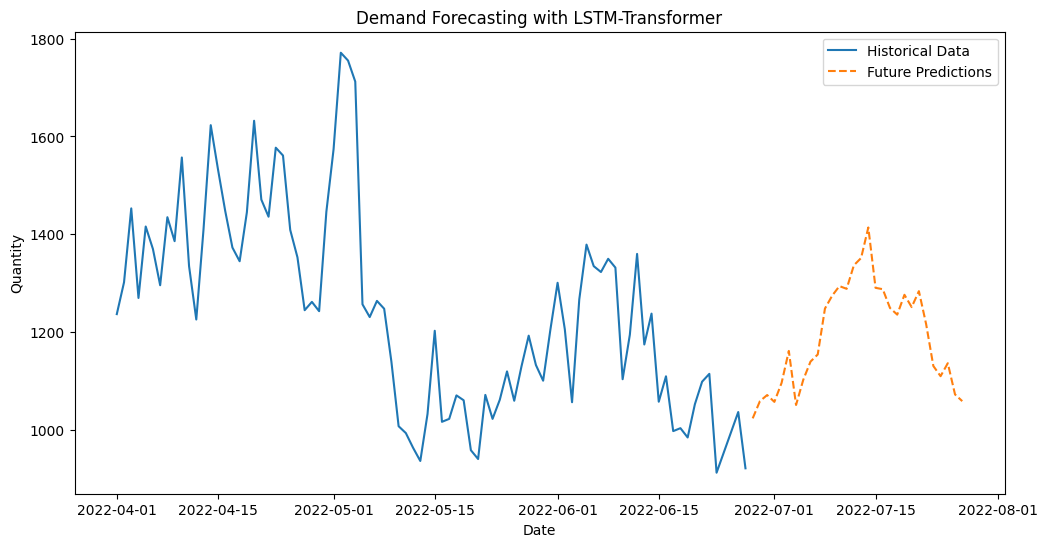

In [30]:
# Forecast future values (rolling prediction)
pred_days = 30
future_preds = []
input_seq = qty_values[-seq_len:].unsqueeze(0).unsqueeze(-1).to(device)

with torch.no_grad():
    for _ in range(pred_days):
        pred = lstm_transformer_model(input_seq)
        future_preds.append(pred.item())
        new_input = torch.cat((input_seq[:, 1:, :], pred.unsqueeze(0)), dim=1)
        input_seq = new_input

# Inverse transform predictions
future_preds = np.array(future_preds).reshape(-1, 1)
future_preds = sc_qty.inverse_transform(future_preds)
window_size = 3
future_preds_smoothed = np.convolve(future_preds.flatten(), np.ones(window_size)/window_size, mode='valid') # Simple Moving Average (SMA)
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], sc_qty.inverse_transform(df['Qty'].values.reshape(-1, 1)), label='Historical Data')
future_dates = pd.date_range(start=df['Date'].iloc[-1] + pd.Timedelta(days=1), periods=pred_days)
plt.plot(future_dates, future_preds, label='Future Predictions', linestyle='--')
plt.legend()
plt.title('Demand Forecasting with LSTM-Transformer')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()
